# Pre-processing

The project problem statement is in the following doc:
https://docs.google.com/document/d/1JVne_JqdAgCUEFqW1DQhL23RJPO05VcnDJ6tT_ltHNI/edit?usp=sharing

## Imports and package insatallations

In [1]:
!pip install siml==0.4.0
!pip install sensormotion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for siml: filename=siml-0.4.0-py3-none-any.whl size=13726 sha256=5f3c248c8d7bd39f999c36a8e4270bf5f33f182d0fbd45f1e8138c1f68f2146f
  Stored in directory: /root/.cache/pip/wheels/78/4a/0b/6d7bfb04dad3de613c870498a7c0132aee2a863b5796a4c10c
Successfully built siml
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sensormotion: filename=sensormotion-1.1.4-py3-none-any.whl size=19675 sha256=4aad9a8a674a25559349708a6d6aed88e4591fb3e9025191ffee5df61ff213fe
  Stored in directory: /root/.cache/pip/wheels/75/d2/43/d129af476d6d0717bcdfc3b7d6ff9b15d65cccdfa21518adac
Successfully built sensormotion


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as sio
import scipy.stats
import math
from IPython.display import display

from siml.sk_utils import *
from siml.signal_analysis_utils import *
import sensormotion as sm
from scipy.fftpack import fft
from scipy.signal import welch
import pywt

import time
import datetime as dt
from collections import defaultdict, Counter

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

import warnings
warnings.filterwarnings("ignore")

## Fetching the Training Data & Processing

In [4]:
from google.colab import files


uploaded = files.upload()

Saving test_labels.csv to test_labels.csv
Saving test_time_series.csv to test_time_series.csv
Saving train_labels.csv to train_labels.csv
Saving train_time_series.csv to train_time_series.csv


In [5]:
train_time_series = pd.read_csv("train_time_series.csv", index_col=0)
train_labels = pd.read_csv("train_labels.csv", index_col=0)
print(train_time_series.shape)
print(train_labels.shape)

(3744, 6)
(375, 3)


In [18]:
def magnitude(activity):
    m2 = activity['x'] * activity['x'] + activity['y'] * activity['y'] + activity['z'] * activity['z']
    m = m2.apply(lambda x: math.sqrt(x))
    return m

train_time_series['m'] = magnitude(train_time_series)
print(train_time_series.head())
print(train_labels.head())
pd.DataFrame.from_dict(Counter(train_labels['label']), orient="index", columns=['label']).reset_index()

train_df = pd.concat([train_time_series, train_labels['label']], axis=1).dropna()
columns = ['timestamp', 'x', 'y', 'z', 'm', 'label']
train_df

           timestamp                 UTC time accuracy         x         y  \
20586  1565109930787  2019-08-06T16:45:30.787  unknown -0.006485 -0.934860   
20587  1565109930887  2019-08-06T16:45:30.887  unknown -0.066467 -1.015442   
20588  1565109930987  2019-08-06T16:45:30.987  unknown -0.043488 -1.021255   
20589  1565109931087  2019-08-06T16:45:31.087  unknown -0.053802 -0.987701   
20590  1565109931188  2019-08-06T16:45:31.188  unknown -0.054031 -1.003616   

              z         m         r  
20586 -0.069046  0.937429  0.937429  
20587  0.089554  1.021548  1.021548  
20588  0.178467  1.037644  1.037644  
20589  0.068985  0.991568  0.991568  
20590  0.126450  1.012993  1.012993  
           timestamp                 UTC time  label
20589  1565109931087  2019-08-06T16:45:31.087      1
20599  1565109932090  2019-08-06T16:45:32.090      1
20609  1565109933092  2019-08-06T16:45:33.092      1
20619  1565109934094  2019-08-06T16:45:34.094      1
20629  1565109935097  2019-08-06T16:45

,timestamp,UTC time,accuracy,x,y,z,m,r,label
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,0.991568,0.991568,1.0
20599,1565109932090,2019-08-06T16:45:32.090,unknown,0.013718,-0.852371,-0.000870,0.852482,0.852482,1.0
20609,1565109933092,2019-08-06T16:45:33.092,unknown,0.145584,-1.007843,-0.036819,1.018969,1.018969,1.0
20619,1565109934094,2019-08-06T16:45:34.094,unknown,-0.099380,-1.209686,0.304489,1.251372,1.251372,1.0
20629,1565109935097,2019-08-06T16:45:35.097,unknown,0.082794,-1.001434,-0.025375,1.005171,1.005171,1.0
...,...,...,...,...,...,...,...,...,...
24289,1565110302030,2019-08-06T16:51:42.030,unknown,-0.641953,-1.469177,0.301041,1.631322,1.631322,4.0
24299,1565110303032,2019-08-06T16:51:43.032,unknown,-0.171616,-0.366074,-0.059082,0.408598,0.408598,4.0
24309,1565110304034,2019-08-06T16:51:44.034,unknown,0.401810,-1.077698,0.258911,1.178948,1.178948,4.0
24319,1565110305037,2019-08-06T16:51:45.037,unknown,0.330338,-1.470062,0.303894,1.537061,1.537061,4.0


## Visualizing Time series data

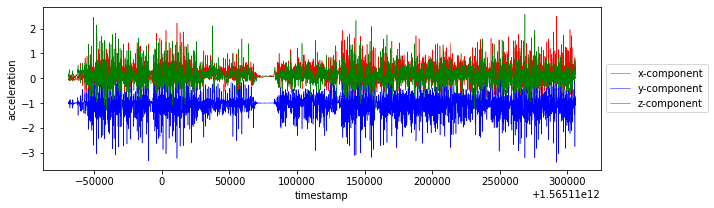

In [13]:
plt.figure(figsize=(10,3))
plt.plot(train_time_series['timestamp'], train_time_series['x'], linewidth=0.5, color='r', label='x-component')
plt.plot(train_time_series['timestamp'], train_time_series['y'], linewidth=0.5, color='b', label='y-component')
plt.plot(train_time_series['timestamp'], train_time_series['z'], linewidth=0.5, color='g', label='z-component')
plt.xlabel('timestamp')
plt.ylabel('acceleration')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Plotting X, Y and Z motion

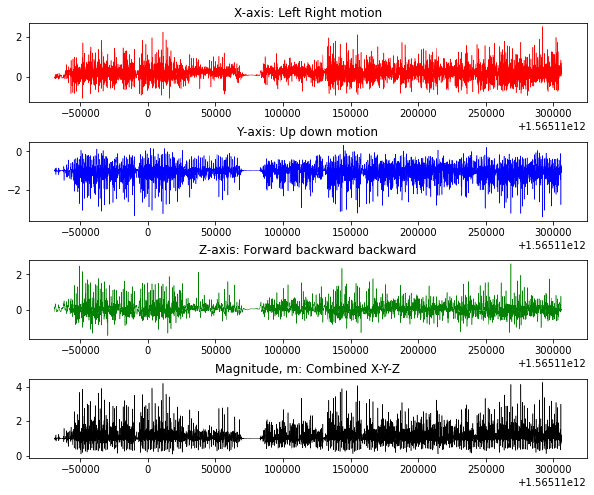

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

ax[0].set_title('X-axis: Left Right motion')
ax[0].plot(train_time_series['timestamp'], train_time_series['x'], linewidth=0.5, color='r')

ax[1].set_title('Y-axis: Up down motion')
ax[1].plot(train_time_series['timestamp'], train_time_series['y'], linewidth=0.5, color='b')

ax[2].set_title('Z-axis: Forward backward backward')
ax[2].plot(train_time_series['timestamp'], train_time_series['z'], linewidth=0.5, color='g')

ax[3].set_title('Magnitude, m: Combined X-Y-Z')
ax[3].plot(train_time_series['timestamp'], train_time_series['m'], linewidth=0.5, color='k')

fig.subplots_adjust(hspace=.5)

## Separating data for each activity

In [19]:
standing = train_df[columns][train_df.label == 1]
walking = train_df[columns][train_df.label == 2]
stairsdown = train_df[columns][train_df.label == 3]
stairsup = train_df[columns][train_df.label == 4]

In [20]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

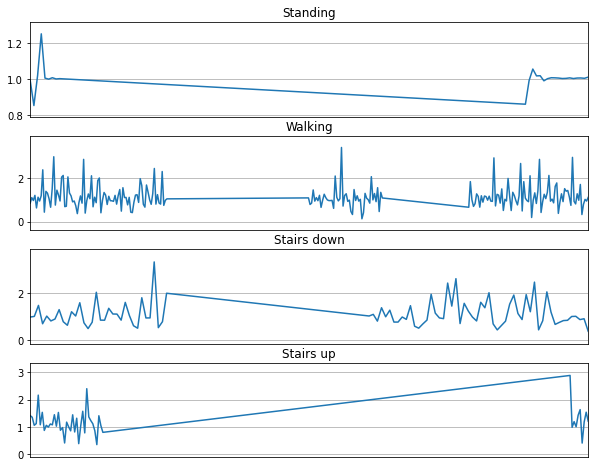

In [21]:
def plot_activity(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(10, 8))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['timestamp'], activities[i]['m'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()

plot_activity([standing, walking, stairsdown, stairsup],
              ['Standing', 'Walking', 'Stairs down', 'Stairs up'])

# Training the model

## Sampling time and frequencies; Creating signals and label arrays

In [22]:
train_time_series['UTC time'] =  pd.to_datetime(train_time_series['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')
train_labels['UTC time'] =  pd.to_datetime(train_labels['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')

# Sampling time and frequency for time series signals 
T_train_ts = np.mean([train_time_series['UTC time'].iloc[i+1]-train_time_series['UTC time'].iloc[i] for i in range(len(train_time_series['UTC time'])-1)])
f_train_ts = len(train_time_series['UTC time'])/(train_time_series['UTC time'].iloc[-1]-train_time_series['UTC time'].iloc[0]).total_seconds()

print("Time-series signals - \nAverage time per sample: {:.2f} seconds\nFrequency per sample: {:.2f} Hz".\
      format(T_train_ts.total_seconds(), f_train_ts))

# Sampling time and frequency for labels
T_train_label = np.mean([train_labels['UTC time'].iloc[i+1]-train_labels['UTC time'].iloc[i] for i in range(len(train_labels['UTC time'])-1)])
f_train_label = len(train_labels['UTC time'])/(train_labels['UTC time'].iloc[-1]-train_labels['UTC time'].iloc[0]).total_seconds()

print("\nActivity labels - \nAverage time per sample: {:.2f} seconds\nFrequency per sample: {:.2f} Hz".\
      format(T_train_label.total_seconds(), f_train_label))

#creating signals
train_x_list = [train_time_series.x.iloc[start:start+10] for start in range(len(train_labels))]
train_y_list = [train_time_series.y.iloc[start:start+10] for start in range(len(train_labels))]
train_z_list = [train_time_series.z.iloc[start:start+10] for start in range(len(train_labels))]
train_m_list = [train_time_series.m.iloc[start:start+10] for start in range(len(train_labels))]
train_signals = np.transpose(np.array([train_x_list, train_y_list, train_z_list, train_m_list]), (1, 2, 0))
train_labels = np.array(train_labels['label'].astype(int))

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train signals array contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The train labels array contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))

Time-series signals - 
Average time per sample: 0.10 seconds
Frequency per sample: 9.98 Hz

Activity labels - 
Average time per sample: 1.00 seconds
Frequency per sample: 1.00 Hz
The train signals array contains 375 signals, each one of length 10 and 4 components 
The train labels array contains 375 labels, with the following distribution:
 Counter({2: 213, 3: 88, 4: 47, 1: 27})


## Frequncy Transformation functions

In [23]:
def randomize(dataset, labels):
   permutation = np.random.permutation(labels.shape[0])
   shuffled_dataset = dataset[permutation, :]
   shuffled_labels = labels[permutation]
   return shuffled_dataset, shuffled_labels

train_signals, train_labels = randomize(train_signals, np.array(train_labels))

def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [(1/f_s) * kk for kk in range(0,len(y_values))]
    return x_values, y_values

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values
    
def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features_ft(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator
            
            features += get_features_ft(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features_ft(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features_ft(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)

## Applying frequency transformation

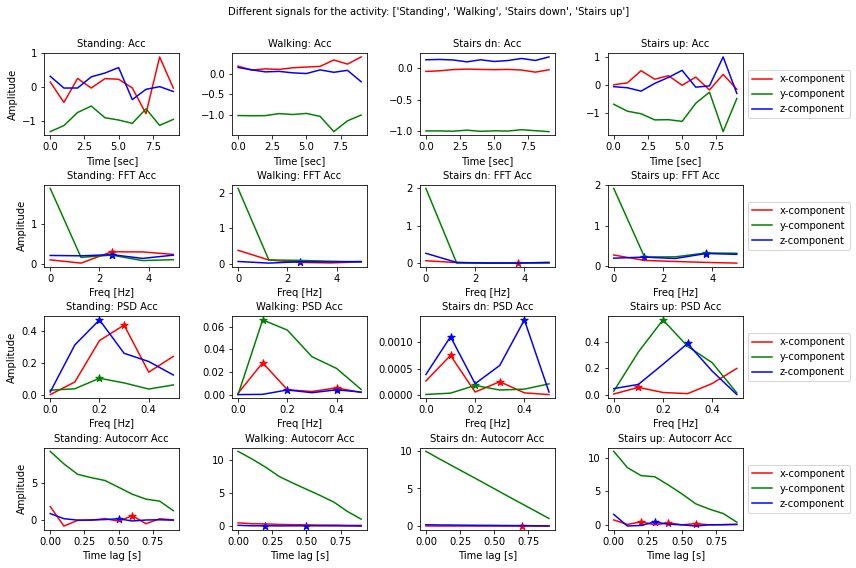

(375, 120)
(375,)


In [26]:
activities_description = {
    1: 'Standing',
    2: 'Walking',
    3: 'Stairs down',
    4: 'Stairs up'
}

N = 10
f_s = 1 #1 Hz for train_labels #10 Hz for train_ts 
t_n = 1 #1 sec for train_labels #0.1 sec for train_ts
T = t_n / N #
sample_rate = 1 / f_s
denominator = 10
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"
 
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Standing: Acc', 'Walking: Acc', 'Stairs dn: Acc', 'Stairs up: Acc'],
            ['Standing: FFT Acc', 'Walking: FFT Acc', 'Stairs dn: FFT Acc', 'Stairs up: FFT Acc'],
            ['Standing: PSD Acc', 'Walking: PSD Acc', 'Stairs dn: PSD Acc', 'Stairs up: PSD Acc'],
            ['Standing: Autocorr Acc', 'Walking: Autocorr Acc', 'Stairs dn: Autocorr Acc', 'Stairs up: Autocorr Acc']
           ]

list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]
signal_no_list = [5, 20, 160, 120]
activity_name = list(activities_description.values())

f, axarr = plt.subplots(nrows=4, ncols=4, figsize=(12,8))
f.suptitle(suptitle.format(activity_name), fontsize=10)
 
for row_no in range(0,4):
    for col_no in range(0,4):
        for comp_no in range(0,3):
            color = colors[comp_no % 3]
            label = labels[comp_no % 3]

            axtitle  = axtitles[row_no][col_no]
            xlabel = xlabels[row_no]
            value_retriever = list_functions[row_no]

            ax = axarr[row_no][col_no]
            ax.set_title(axtitle, fontsize=10)
            ax.set_xlabel(xlabel, fontsize=10)
            
            if col_no == 0:
                ax.set_ylabel(ylabel, fontsize=10)
            signal_no = signal_no_list[col_no]
            signals = train_signals[signal_no, :, :]
            signal_component = signals[:, comp_no]
            x_values, y_values = value_retriever(signal_component, T, N, f_s)
            ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
            
            if row_no > 0:
                max_peak_height = 0.1 * np.nanmax(y_values)
                indices_peaks = detect_peaks(y_values, mph=max_peak_height)
                ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
            if col_no == 3:
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

X_train_ft, Y_train_ft = extract_features_labels(train_signals, train_labels, T, N, f_s, denominator)
print(X_train_ft.shape)
print(Y_train_ft.shape)

## Train the classifiers

In [27]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_ft, Y_train_ft, train_size=0.8, random_state=1)
models = batch_classify(X_train, Y_train, X_val, Y_val)
display_dict_models(models)

trained Gradient Boosting Classifier in 1.30 s
trained Random Forest in 0.17 s
trained Logistic Regression in 0.05 s
trained Nearest Neighbors in 0.00 s
trained Decision Tree in 0.01 s


,classifier,train_score,test_score,train_time
0,Gradient Boosting Classifier,1.000000,0.800000,1.295001
1,Random Forest,1.000000,0.800000,0.166007
2,Logistic Regression,0.716667,0.680000,0.053369
3,Nearest Neighbors,0.736667,0.653333,0.002131
4,Decision Tree,1.000000,0.653333,0.014796


In [29]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_ros, Y_ros = ros.fit_resample(X_train, Y_train)
models = batch_classify(X_ros, Y_ros, X_val, Y_val)
display_dict_models(models)

trained Gradient Boosting Classifier in 1.56 s
trained Random Forest in 0.19 s
trained Logistic Regression in 0.23 s
trained Nearest Neighbors in 0.00 s
trained Decision Tree in 0.02 s


,classifier,train_score,test_score,train_time
0,Gradient Boosting Classifier,1.000000,0.813333,1.563180
1,Random Forest,1.000000,0.800000,0.193427
4,Decision Tree,1.000000,0.653333,0.020080
2,Logistic Regression,0.787202,0.586667,0.225686
3,Nearest Neighbors,0.882440,0.533333,0.002176


# Best Classifier

In [33]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=7, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_ros, Y_ros)

clf = rf_random.best_estimator_
clf.fit(X_ros, Y_ros)
print("Accuracy on training set is : {}".format(clf.score(X_ros, Y_ros)))
print("Accuracy on validation set is : {}".format(clf.score(X_val, Y_val)))
Y_val_pred = clf.predict(X_val)
print(classification_report(Y_val, Y_val_pred))

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy on training set is : 1.0
Accuracy on validation set is : 0.84
              precision    recall  f1-score   support

           1       1.00      0.29      0.44         7
           2       0.81      0.98      0.89        45
           3       0.85      0.73      0.79        15
           4       1.00      0.75      0.86         8

    accuracy                           0.84        75
   macro avg       0.92      0.69      0.74        75
weighted avg       0.86      0.84      0.82        75



In [34]:
print("Counter on validation set:", Counter(Y_val_pred))
print("Predicted activities:\n", list(Y_val_pred))
pred_activities = [activities_description[label] for label in list(Y_val_pred)]
print("Predicted Activities:\n", pred_activities)

Counter on validation set: Counter({2: 54, 3: 13, 4: 6, 1: 2})
Predicted activities:
 [4, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3, 2, 4, 3, 4, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 3, 2, 4, 3, 2, 2, 2]
Predicted Activities:
 ['Stairs up', 'Walking', 'Stairs down', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Standing', 'Walking', 'Stairs down', 'Stairs down', 'Walking', 'Stairs up', 'Stairs down', 'Stairs up', 'Stairs down', 'Walking', 'Stairs down', 'Stairs down', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Standing', 'Walking', 'Walking', 'Walking', 'Stairs down', 'Walking', 'Walking', 'Walking', 'Stairs down', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Stairs up', 'Stairs down', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking'